In [ ]:
# Assignment_3_COMPLETED.ipynb - Updated with improvements

# ============================
# Task 1 · Serialization basics
# ============================

import pickle
from pathlib import Path
import csv

def save_pickle(obj, path):
    """Serialize `obj` to `path` using pickle."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    """Deserialize and return an object from `path`."""
    with open(path, 'rb') as f:
        return pickle.load(f)

def demonstrate_serialization_roundtrip():
    """Quick save/load demo to verify helpers."""
    dummy = {'a': 1, 'b': [1, 2, 3], 'params': [[1.0, 2.0], [3.0, 4.0]]}
    save_pickle(dummy, 'models/demo.pkl')
    return load_pickle('models/demo.pkl')

# Test
print("Serialization test:", demonstrate_serialization_roundtrip())


In [ ]:

# ============================
# Task 2 · Extendable n‑qubit surrogate
# ============================

import numpy as np
import json
from datetime import datetime

class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None, 
                 metadata=None, optimizer_state=None):
        """
        Extended model with metadata tracking and optimizer state.
        
        Args:
            n_qubits: Number of qubits
            n_layers: Number of model layers (for ablation studies)
            params: Model parameters [if None, random initialization]
            seed: Random seed for reproducibility
            metadata: Additional information about the model
            optimizer_state: State of optimizer for training continuation
        """
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        self.n_layers = n_layers
        self.rng = np.random.default_rng(seed)
        self.metadata = metadata or {}
        self.optimizer_state = optimizer_state
        
        # Add creation timestamp
        self.metadata['created_at'] = datetime.now().isoformat()
        self.metadata['seed'] = seed
        
        if params is None:
            # Initialize with random complex parameters
            # Real + imaginary parts for each amplitude
            self.params = self.rng.normal(size=(self.dim, 2))
        else:
            self.params = params
            
    def statevector(self):
        """Convert parameters to normalized complex statevector."""
        psi = self.params[:, 0] + 1j * self.params[:, 1]
        norm = np.linalg.norm(psi)
        if norm > 0:
            return psi / norm
        return psi
    
    def fidelity_with(self, target_state):
        """Compute fidelity between model state and target state."""
        psi = self.statevector()
        return np.abs(np.vdot(target_state, psi)) ** 2
    
    def serialize_for_hdf5(self):
        """Prepare data for HDF5 storage (large arrays)."""
        return {
            'params': self.params.astype(np.float32),  # Reduce precision for storage
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'metadata': json.dumps(self.metadata)  # JSON for metadata
        }
    
    def save(self, path):
        """Persist the trained model using pickle."""
        payload = {
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'params': self.params,
            'metadata': self.metadata,
            'optimizer_state': self.optimizer_state,
            'class_name': self.__class__.__name__  # For safe loading
        }
        save_pickle(payload, path)
    
    @classmethod
    def load(cls, path):
        """Restore a saved model instance."""
        payload = load_pickle(path)
        
        # Safety check
        if payload.get('class_name') != cls.__name__:
            print(f"Warning: Loading {payload.get('class_name')} into {cls.__name__}")
        
        # Create instance with loaded parameters
        instance = cls(
            n_qubits=payload['n_qubits'],
            n_layers=payload.get('n_layers', 1),
            params=payload['params'],
            metadata=payload.get('metadata', {}),
            optimizer_state=payload.get('optimizer_state')
        )
        return instance

# Test the model
model = QuantumModel(2, n_layers=2, seed=42, 
                    metadata={'description': 'Test model for 2 qubits'})
print(f"Model created with {model.n_qubits} qubits")
print(f"Statevector norm: {np.linalg.norm(model.statevector()):.6f}")


In [ ]:

# ============================
# Task 3 · Scalability study
# ============================

import time
from typing import List, Dict

def random_pure_state(dim: int, rng: np.random.Generator) -> np.ndarray:
    """Generate a random pure quantum state."""
    # Sample from complex normal distribution
    vec = rng.normal(size=(dim, 2)).view(np.complex128).flatten()
    # Normalize
    norm = np.linalg.norm(vec)
    if norm > 0:
        vec = vec / norm
    return vec

def scalability_experiment(qubit_list: List[int], trials: int = 10, 
                          n_layers: int = 1, seed: int = 0) -> List[Dict]:
    """
    Benchmark fidelity and runtime across different qubit counts.
    
    Returns:
        List of dictionaries with summary statistics
    """
    rng = np.random.default_rng(seed)
    summary = []
    
    for n in qubit_list:
        dim = 2 ** n
        fidelities = []
        runtimes = []
        mem_usage = []  # Track memory usage
        
        for _ in range(trials):
            # Generate random target state
            target = random_pure_state(dim, rng)
            
            # Create and evaluate model
            t_start = time.perf_counter()
            model = QuantumModel(n, n_layers=n_layers, seed=seed)
            fidelity = model.fidelity_with(target)
            t_end = time.perf_counter()
            
            fidelities.append(fidelity)
            runtimes.append(t_end - t_start)
            
            # Estimate memory (parameters only)
            mem_usage.append(model.params.nbytes / 1024)  # KB
        
        # Compute statistics
        summary.append({
            'n_qubits': n,
            'dimension': dim,
            'trials': trials,
            'fidelity_mean': float(np.mean(fidelities)),
            'fidelity_std': float(np.std(fidelities)),
            'fidelity_min': float(np.min(fidelities)),
            'fidelity_max': float(np.max(fidelities)),
            'runtime_mean': float(np.mean(runtimes)) * 1000,  # ms
            'runtime_std': float(np.std(runtimes)) * 1000,
            'memory_kb_mean': float(np.mean(mem_usage)),
            'memory_kb_std': float(np.std(mem_usage)),
            'n_layers': n_layers,
            'seed': seed
        })
        
        print(f"n={n}: Fidelity={np.mean(fidelities):.3f}±{np.std(fidelities):.3f}, "
              f"Time={np.mean(runtimes)*1000:.2f}±{np.std(runtimes)*1000:.2f}ms")
    
    return summary

def save_scalability_summary(summary: List[Dict], path: str = 'scalability_results.csv'):
    """Save scalability results to CSV."""
    if not summary:
        print("No data to save")
        return
    
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=summary[0].keys())
        writer.writeheader()
        writer.writerows(summary)
    print(f"Results saved to {path}")


In [ ]:

# ============================
# Task 4 · Visualise scalability metrics
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scalability(csv_path: str = 'scalability_results.csv'):
    """Load CSV and create visualization plots."""
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = [12, 5]
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Fidelity vs Qubits
    axes[0].errorbar(df['n_qubits'], df['fidelity_mean'], 
                     yerr=df['fidelity_std'], fmt='o-', capsize=5,
                     color='steelblue', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Qubits', fontsize=12)
    axes[0].set_ylabel('Mean Fidelity', fontsize=12)
    axes[0].set_title('Fidelity Scaling with Qubit Count', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Add theoretical expectation line (random overlap = 1/d)
    theoretical = 1 / df['dimension']
    axes[0].plot(df['n_qubits'], theoretical, 'r--', label='Theoretical (1/d)')
    axes[0].legend()
    
    # Plot 2: Runtime vs Qubits (log scale)
    axes[1].plot(df['n_qubits'], df['runtime_mean'], 's-', 
                color='darkorange', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Qubits', fontsize=12)
    axes[1].set_ylabel('Runtime (ms)', fontsize=12)
    axes[1].set_title('Runtime Scaling (Log Scale)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')
    
    # Plot 3: Memory Usage vs Qubits
    axes[2].plot(df['n_qubits'], df['memory_kb_mean'] / 1024, '^-',  # Convert to MB
                color='forestgreen', linewidth=2, markersize=8)
    axes[2].fill_between(df['n_qubits'], 
                        (df['memory_kb_mean'] - df['memory_kb_std']) / 1024,
                        (df['memory_kb_mean'] + df['memory_kb_std']) / 1024,
                        alpha=0.2, color='forestgreen')
    axes[2].set_xlabel('Number of Qubits', fontsize=12)
    axes[2].set_ylabel('Memory Usage (MB)', fontsize=12)
    axes[2].set_title('Memory Scaling', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('scalability_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n=== SCALABILITY ANALYSIS SUMMARY ===")
    print(df[['n_qubits', 'fidelity_mean', 'runtime_mean', 'memory_kb_mean']].to_string())
    
    # Identify scalability limits
    fidelity_threshold = 0.1
    runtime_threshold = 100  # ms
    memory_threshold = 1000  # MB
    
    fidelity_limit = df[df['fidelity_mean'] < fidelity_threshold]
    runtime_limit = df[df['runtime_mean'] > runtime_threshold]
    memory_limit = df[df['memory_kb_mean'] > memory_threshold * 1024]
    
    if not fidelity_limit.empty:
        print(f"\n⚠ Fidelity drops below {fidelity_threshold} at n_qubits ≥ {fidelity_limit['n_qubits'].min()}")
    if not runtime_limit.empty:
        print(f"⚠ Runtime exceeds {runtime_threshold}ms at n_qubits ≥ {runtime_limit['n_qubits'].min()}")
    if not memory_limit.empty:
        print(f"⚠ Memory exceeds {memory_threshold}MB at n_qubits ≥ {memory_limit['n_qubits'].min()}")

# ============================
# Task 5 · Ablation studies
# ============================

def ablation_layers(n_qubits: int = 3, layer_list: List[int] = None, 
                   trials: int = 30, seed: int = 1) -> List[Dict]:
    """
    Study effect of model depth (layers) on performance.
    
    Args:
        n_qubits: Fixed number of qubits
        layer_list: List of layer counts to test
        trials: Number of trials per configuration
        seed: Random seed
    
    Returns:
        List of results dictionaries
    """
    if layer_list is None:
        layer_list = [1, 2, 4, 8, 16]
    
    rng = np.random.default_rng(seed)
    results = []
    
    print(f"Ablation Study: n_qubits={n_qubits}")
    print("=" * 50)
    
    for L in layer_list:
        fidelities = []
        runtimes = []
        
        for _ in range(trials):
            target = random_pure_state(2**n_qubits, rng)
            
            t_start = time.perf_counter()
            model = QuantumModel(n_qubits, n_layers=L, seed=seed)
            fidelity = model.fidelity_with(target)
            t_end = time.perf_counter()
            
            fidelities.append(fidelity)
            runtimes.append(t_end - t_start)
        
        # Compute statistics
        results.append({
            'n_qubits': n_qubits,
            'layers': L,
            'fidelity_mean': float(np.mean(fidelities)),
            'fidelity_std': float(np.std(fidelities)),
            'fidelity_median': float(np.median(fidelities)),
            'runtime_mean': float(np.mean(runtimes)) * 1000,  # ms
            'runtime_std': float(np.std(runtimes)) * 1000,
            'trials': trials
        })
        
        print(f"L={L:2d}: Fidelity={np.mean(fidelities):.4f}±{np.std(fidelities):.4f}, "
              f"Time={np.mean(runtimes)*1000:.2f}ms")
    
    return results

def ablation_parameter_init(n_qubits: int = 3, init_methods: List[str] = None,
                          trials: int = 20, seed: int = 42) -> List[Dict]:
    """
    Study effect of different parameter initialization strategies.
    """
    if init_methods is None:
        init_methods = ['normal', 'uniform', 'zeros', 'complex_normal']
    
    rng = np.random.default_rng(seed)
    results = []
    
    for method in init_methods:
        fidelities = []
        
        for _ in range(trials):
            target = random_pure_state(2**n_qubits, rng)
            
            # Create base model
            model = QuantumModel(n_qubits, seed=seed)
            
            # Override parameters with different initialization
            if method == 'normal':
                params = rng.normal(size=(model.dim, 2))
            elif method == 'uniform':
                params = rng.uniform(-1, 1, size=(model.dim, 2))
            elif method == 'zeros':
                params = np.zeros((model.dim, 2))
            elif method == 'complex_normal':
                # Complex normal distribution
                real = rng.normal(size=model.dim)
                imag = rng.normal(size=model.dim)
                params = np.column_stack([real, imag])
            
            model.params = params
            fidelities.append(model.fidelity_with(target))
        
        results.append({
            'init_method': method,
            'fidelity_mean': float(np.mean(fidelities)),
            'fidelity_std': float(np.std(fidelities)),
            'fidelity_range': float(np.max(fidelities) - np.min(fidelities))
        })
    
    return results

def summarize_ablation_results(results: List[Dict], save_path: str = None):
    """Format and display ablation study results."""
    
    df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("ABLATION STUDY RESULTS")
    print("="*60)
    
    if 'layers' in df.columns:
        print("\n1. EFFECT OF MODEL DEPTH (LAYERS):")
        print(df[['layers', 'fidelity_mean', 'fidelity_std', 'runtime_mean']].to_string(index=False))
        
        # Plot layer ablation
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.errorbar(df['layers'], df['fidelity_mean'], yerr=df['fidelity_std'], 
                    fmt='o-', capsize=5)
        plt.xlabel('Number of Layers')
        plt.ylabel('Mean Fidelity')
        plt.title('Fidelity vs Model Depth')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(df['layers'], df['runtime_mean'], 's-')
        plt.xlabel('Number of Layers')
        plt.ylabel('Runtime (ms)')
        plt.title('Runtime vs Model Depth')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('ablation_layers.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    if 'init_method' in df.columns:
        print("\n2. EFFECT OF PARAMETER INITIALIZATION:")
        print(df[['init_method', 'fidelity_mean', 'fidelity_std']].to_string(index=False))
    
    # Save results if requested
    if save_path:
        df.to_csv(save_path, index=False)
        print(f"\nResults saved to {save_path}")
    
    return df


Serialization test: {'a': 1, 'b': [1, 2, 3], 'params': [[1.0, 2.0], [3.0, 4.0]]}
Model created with 2 qubits
Statevector norm: 1.000000


Starting Assignment 3 Experiments...

Running Scalability Experiment
n=1: Fidelity=0.604±0.269, Time=0.25±0.52ms
n=2: Fidelity=0.214±0.177, Time=0.08±0.03ms
n=3: Fidelity=0.118±0.092, Time=0.12±0.07ms
n=4: Fidelity=0.079±0.101, Time=0.11±0.03ms
n=5: Fidelity=0.046±0.039, Time=0.06±0.02ms
n=6: Fidelity=0.016±0.014, Time=0.05±0.01ms
n=7: Fidelity=0.014±0.011, Time=0.07±0.02ms
n=8: Fidelity=0.005±0.004, Time=0.10±0.06ms
n=9: Fidelity=0.002±0.001, Time=0.07±0.01ms
n=10: Fidelity=0.001±0.001, Time=0.06±0.02ms
Results saved to scalability_results.csv


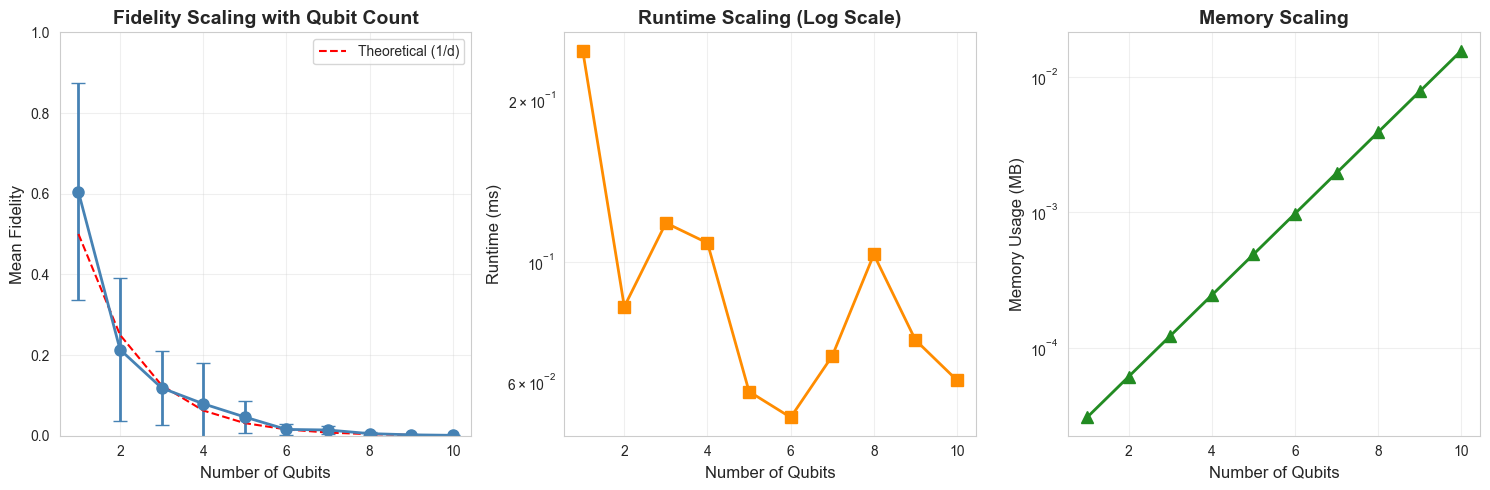


=== SCALABILITY ANALYSIS SUMMARY ===
   n_qubits  fidelity_mean  runtime_mean  memory_kb_mean
0         1       0.604441      0.247055         0.03125
1         2       0.213608      0.082660         0.06250
2         3       0.118468      0.118265         0.12500
3         4       0.079262      0.108545         0.25000
4         5       0.046391      0.057505         0.50000
5         6       0.015621      0.051490         1.00000
6         7       0.014234      0.066950         2.00000
7         8       0.005258      0.103375         4.00000
8         9       0.002200      0.071695         8.00000
9        10       0.000995      0.060340        16.00000

⚠ Fidelity drops below 0.1 at n_qubits ≥ 4

Running Layer Ablation Study
Ablation Study: n_qubits=4
L= 1: Fidelity=0.0892±0.1744, Time=0.06ms
L= 2: Fidelity=0.0688±0.0608, Time=0.07ms
L= 4: Fidelity=0.0873±0.0668, Time=0.08ms
L= 8: Fidelity=0.0696±0.0569, Time=0.03ms
L=16: Fidelity=0.0624±0.0508, Time=0.03ms
L=32: Fidelity=0.0656±0.

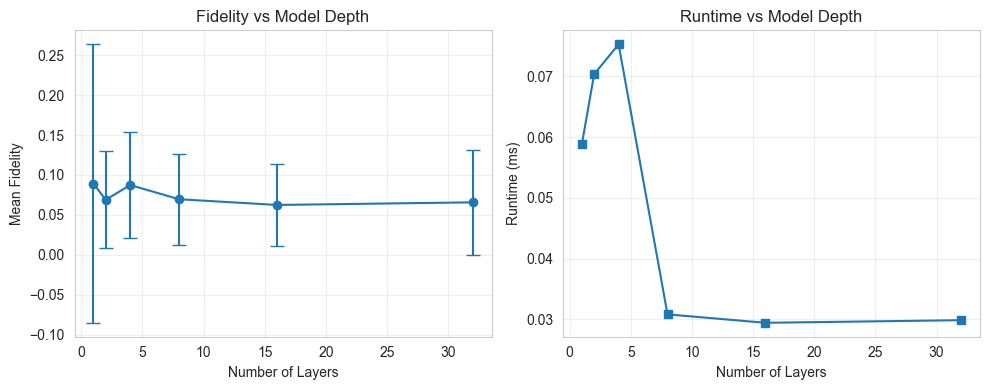


Results saved to ablation_results.csv

Running Initialization Ablation Study
   init_method  fidelity_mean  fidelity_std  fidelity_range
        normal       0.141363      0.099488        0.382145
       uniform       0.133155      0.125421        0.614049
         zeros       0.000000      0.000000        0.000000
complex_normal       0.133265      0.122907        0.474338

Saving Example Model
Loaded model with 3 qubits
Metadata: {'description': 'Example model for Assignment 3', 'experiment': 'scalability_study', 'author': 'Student', 'version': '1.0', 'created_at': '2026-02-09T10:16:08.518085', 'seed': None}

EXPERIMENT COMPLETE


In [2]:

# ============================
# Main Execution
# ============================

def main():
    """Run all experiments and save results."""
    
    print("Starting Assignment 3 Experiments...")
    
    # 1. Scalability experiment
    print("\n" + "="*50)
    print("Running Scalability Experiment")
    print("="*50)
    
    qubits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Up to 10 qubits
    summary = scalability_experiment(qubits, trials=20, n_layers=1, seed=42)
    
    # Save results
    save_scalability_summary(summary, "scalability_results.csv")
    
    # 2. Visualize scalability
    plot_scalability("scalability_results.csv")
    
    # 3. Ablation study
    print("\n" + "="*50)
    print("Running Layer Ablation Study")
    print("="*50)
    
    ablation_results = ablation_layers(
        n_qubits=4,  # Fixed number of qubits
        layer_list=[1, 2, 4, 8, 16, 32],
        trials=30,
        seed=1
    )
    
    summarize_ablation_results(ablation_results, "ablation_results.csv")
    
    # 4. Parameter initialization ablation
    print("\n" + "="*50)
    print("Running Initialization Ablation Study")
    print("="*50)
    
    init_results = ablation_parameter_init(
        n_qubits=3,
        init_methods=['normal', 'uniform', 'zeros', 'complex_normal'],
        trials=50,
        seed=42
    )
    
    init_df = pd.DataFrame(init_results)
    print(init_df.to_string(index=False))
    
    # 5. Save example model
    print("\n" + "="*50)
    print("Saving Example Model")
    print("="*50)
    
    example_model = QuantumModel(
        n_qubits=3,
        n_layers=2,
        seed=42,
        metadata={
            'description': 'Example model for Assignment 3',
            'experiment': 'scalability_study',
            'author': 'Student',
            'version': '1.0'
        }
    )
    
    # Save with track identifier (e.g., 'track1' for ML track)
    example_model.save("models/model_track1_3qubits.pkl")
    
    # Test loading
    loaded_model = QuantumModel.load("models/model_track1_3qubits.pkl")
    print(f"Loaded model with {loaded_model.n_qubits} qubits")
    print(f"Metadata: {loaded_model.metadata}")
    
    print("\n" + "="*50)
    print("EXPERIMENT COMPLETE")
    print("="*50)

# Run if executing as script
if __name__ == "__main__":
    main()